In [1]:
# Project Template Import Cell
%matplotlib inline
import os
import sys
import math

from __future__ import print_function, division
from inspect import getsourcefile

from IPython.display import FileLink

# Standard Notebook Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.width', 120)

CURR_PATH = os.path.abspath(getsourcefile(lambda:0)).rsplit('/', 1)[0] # Get filepath of this notebook
module_path = os.path.join(os.path.dirname(CURR_PATH), 'utils') # Make module path for one dir up and one down into utils
if module_path not in sys.path: # Append to system path list
    sys.path.append(module_path)

import utils as utils ; reload(utils)

print('System : Python ', os.sys.version , '\n\n')

print('Directory Structure:')
print(CURR_PATH)
!tree -cn --filelimit 20

# Keras Setup
import keras
print('\n\nKeras version:' , keras.__version__ ,
      ', backend:' , keras.backend.backend(),
      ', image_format:' , keras.backend.image_data_format())

random_seed = 7

print('\n\nEnvironment : ')
FileLink('../../ana_py27_p2.yml')
#print(sys.path)

Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


System : Python  2.7.12 | packaged by conda-forge | (default, Sep  8 2016, 14:22:31) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)] 


Directory Structure:
/home/ubuntu/ana_py27_p2/projects/CervicalCancer
.
├── unused_utils
│   ├── __init__.py
│   ├── __init__.pyc
│   ├── utils.pyc
│   └── unused_utils.py
├── __init__.py
├── 003 - Baseline.ipynb
├── 002 - Sample Setup.ipynb
├── 001 - Initial Setup.ipynb
├── data
│   ├── additional_Type_1_v2.7z
│   ├── additional_Type_3_v2.7z
│   ├── additional_Type_2_v2.7z
│   ├── train
│   │   ├── Type_1 [168 entries exceeds filelimit, not opening dir]
│   │   ├── Type_2 [524 entries exceeds filelimit, not opening dir]
│   │   └── Type_3 [302 entries exceeds filelimit, not opening dir]
│   ├── test
│   │   └── unknown [512 entries exceeds filelimit, not opening dir]
│   ├── preview
│   ├── downloads
│   │   ├── sample_submission.csv.zip
│   │   ├── test.7z
│   │   └── train.7z
│   ├── valid
│   │   ├── Type_1 [82 entries exceeds filelimit, not opening dir]


/home/ubuntu/ana_py27_p2/ana_py27_p2.yml

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.callbacks import ModelCheckpoint

In [3]:
# Hopefully a fix for truncated image error identified below on first epoch
# http://stackoverflow.com/questions/12984426/python-pil-ioerror-image-file-truncated-with-big-images

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
img_width, img_height = 150, 150

In [5]:
#train_data_dir = 'data/sample/train'
#validation_data_dir = 'data/sample/valid'
#test_data_dir = 'data/sample/test'
#weights_dir = 'data/sample/weights'

train_data_dir = 'data/train'
validation_data_dir = 'data/valid'
test_data_dir = 'data/test'
weights_dir = 'data/weights'

submission_dir = 'data/submissions'

num_training_samples = 0
for class_dir in utils.get_non_hidden_dir_contents(train_data_dir):
    num_training_samples += len(utils.get_non_hidden_dir_contents(class_dir))
num_validation_samples = 0
for class_dir in utils.get_non_hidden_dir_contents(validation_data_dir):
    num_validation_samples += len(utils.get_non_hidden_dir_contents(class_dir))    

print(num_training_samples)
print(num_validation_samples)

994
487


In [6]:
input_shape = (img_width, img_height, 3)
epochs = 40
batch_size=64
train_steps = int(math.ceil(num_training_samples / batch_size))
validation_steps =  int(math.ceil(num_validation_samples / batch_size))
print(train_steps)
print(validation_steps)

16
8


In [7]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

In [8]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
            metrics=['accuracy'])

In [10]:
# checkpoint
# http://machinelearningmastery.com/check-point-deep-learning-models-keras/
filen="weights1-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
filepath = os.path.join(weights_dir, filen)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
#callbacks_list=None

In [11]:
train_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [12]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    classes = ['Type_1', 'Type_2', 'Type_3'],
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    classes = ['Type_1', 'Type_2', 'Type_3'],
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

Found 994 images belonging to 3 classes.
Found 487 images belonging to 3 classes.


In [13]:
# Use this for preliminary timing on the AWS p2 instance, so can estimate a good size for the sample directory files
import time
start_time = time.time()

In [14]:
# Based on number of training images per Type in train_dir
class_weight_dict = utils.get_class_weight_dict([168, 524, 302])
print(class_weight_dict)

{0: 3.119047619047619, 1: 1.0, 2: 1.7350993377483444}


In [15]:
h = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps, 
    class_weight = class_weight_dict,
    callbacks=callbacks_list,
    verbose=1)

Epoch 1/40
16/16 [==============================] - 321s - loss: 1.7343 - acc: 0.3256 - val_loss: 1.0990 - val_acc: 0.2875
Epoch 2/40
16/16 [==============================] - 205s - loss: 1.7350 - acc: 0.3217 - val_loss: 1.1000 - val_acc: 0.2690
Epoch 3/40
16/16 [==============================] - 207s - loss: 1.7228 - acc: 0.3398 - val_loss: 1.1011 - val_acc: 0.2669
Epoch 4/40
16/16 [==============================] - 204s - loss: 1.7261 - acc: 0.3350 - val_loss: 1.0959 - val_acc: 0.2895
Epoch 5/40
16/16 [==============================] - 215s - loss: 1.7223 - acc: 0.3401 - val_loss: 1.0921 - val_acc: 0.3039
Epoch 6/40
16/16 [==============================] - 205s - loss: 1.7108 - acc: 0.4240 - val_loss: 1.0670 - val_acc: 0.4476
Epoch 7/40
16/16 [==============================] - 204s - loss: 1.6976 - acc: 0.4173 - val_loss: 1.0966 - val_acc: 0.2813
Epoch 8/40
16/16 [==============================] - 202s - loss: 1.6867 - acc: 0.3882 - val_loss: 1.0867 - val_acc: 0.2957
Epoch 9/40
16/16

### Error
Getting the error below - Suspsect it is to do with big images

Trying this fix
http://stackoverflow.com/questions/12984426/python-pil-ioerror-image-file-truncated-with-big-images

`from PIL import ImageFile`
`ImageFile.LOAD_TRUNCATED_IMAGES = True`



Epoch 1/40
15/16 [===========================>..] - ETA: 13s - loss: 1.7411 - acc: 0.2885

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda2/envs/ana_py27_p2/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda2/envs/ana_py27_p2/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/home/ubuntu/anaconda2/envs/ana_py27_p2/lib/python2.7/site-packages/keras/engine/training.py", line 606, in data_generator_task
    generator_output = next(self._generator)
  File "/home/ubuntu/anaconda2/envs/ana_py27_p2/lib/python2.7/site-packages/keras/preprocessing/image.py", line 960, in next
    target_size=self.target_size)
  File "/home/ubuntu/anaconda2/envs/ana_py27_p2/lib/python2.7/site-packages/keras/preprocessing/image.py", line 330, in load_img
    img = img.resize(wh_tuple)
  File "/home/ubuntu/anaconda2/envs/ana_py27_p2/lib/python2.7/site-packages/PIL/Image.py", line 1630, in resize
    self.load()
  File "/home/ubuntu/anaconda2/envs/ana_py27_p2/lib/python2.7/site-packages/PIL/ImageFile.py", line 231, in load
    "(%d bytes not processed)" % len(b))
IOError: image file is truncated (54 bytes not processed)

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-14-096835ec6394> in <module>()
      7     class_weight = class_weight_dict,
      8     callbacks=callbacks_list,
----> 9     verbose=1)

/home/ubuntu/anaconda2/envs/ana_py27_p2/lib/python2.7/site-packages/keras/legacy/interfaces.pyc in wrapper(*args, **kwargs)
     86                 warnings.warn('Update your `' + object_name +
     87                               '` call to the Keras 2 API: ' + signature, stacklevel=2)
---> 88             return func(*args, **kwargs)
     89         wrapper._legacy_support_signature = inspect.getargspec(func)
     90         return wrapper

/home/ubuntu/anaconda2/envs/ana_py27_p2/lib/python2.7/site-packages/keras/models.pyc in fit_generator(self, generator, steps_per_epoch, epochs, verbose, callbacks, validation_data, validation_steps, class_weight, max_q_size, workers, pickle_safe, initial_epoch)
   1095                                         workers=workers,
   1096                                         pickle_safe=pickle_safe,
-> 1097                                         initial_epoch=initial_epoch)
   1098 
   1099     @interfaces.legacy_generator_methods_support

/home/ubuntu/anaconda2/envs/ana_py27_p2/lib/python2.7/site-packages/keras/legacy/interfaces.pyc in wrapper(*args, **kwargs)
     86                 warnings.warn('Update your `' + object_name +
     87                               '` call to the Keras 2 API: ' + signature, stacklevel=2)
---> 88             return func(*args, **kwargs)
     89         wrapper._legacy_support_signature = inspect.getargspec(func)
     90         return wrapper

/home/ubuntu/anaconda2/envs/ana_py27_p2/lib/python2.7/site-packages/keras/engine/training.pyc in fit_generator(self, generator, steps_per_epoch, epochs, verbose, callbacks, validation_data, validation_steps, class_weight, max_q_size, workers, pickle_safe, initial_epoch)
   1896                                 max_q_size=max_q_size,
   1897                                 workers=workers,
-> 1898                                 pickle_safe=pickle_safe)
   1899                         else:
   1900                             # No need for try/except because

/home/ubuntu/anaconda2/envs/ana_py27_p2/lib/python2.7/site-packages/keras/legacy/interfaces.pyc in wrapper(*args, **kwargs)
     86                 warnings.warn('Update your `' + object_name +
     87                               '` call to the Keras 2 API: ' + signature, stacklevel=2)
---> 88             return func(*args, **kwargs)
     89         wrapper._legacy_support_signature = inspect.getargspec(func)
     90         return wrapper

/home/ubuntu/anaconda2/envs/ana_py27_p2/lib/python2.7/site-packages/keras/engine/training.pyc in evaluate_generator(self, generator, steps, max_q_size, workers, pickle_safe)
   1982                                      '(x, y, sample_weight) '
   1983                                      'or (x, y). Found: ' +
-> 1984                                      str(generator_output))
   1985                 if len(generator_output) == 2:
   1986                     x, y = generator_output

ValueError: output of generator should be a tuple (x, y, sample_weight) or (x, y). Found: None






In [16]:
# Use this for preliminary timing on the AWS p2 instance, so can estimate a good size for the sample directory files
print("%f seconds" % (time.time() - start_time))
print('Total Images Processed ' , str(num_training_samples + num_validation_samples))
print('Epochs :', str(h.epoch[-1]+ 1))

8407.520051 seconds
Total Images Processed  1481
Epochs : 40


In [17]:
#stop

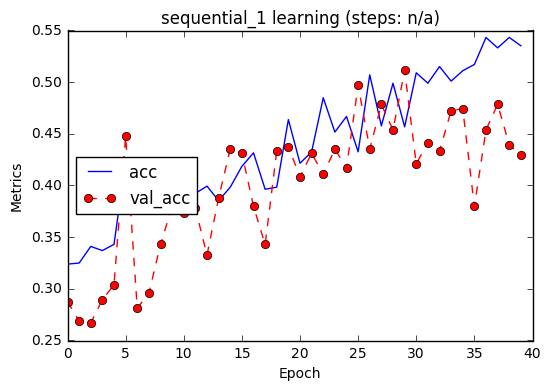

In [18]:
utils.plot_learning(h)

In [30]:
fns = utils.get_non_hidden_dir_contents(os.path.join(test_data_dir, 'unknown'))
#test_batch_size = len(fns)
pred_batch_size= 57
pred_steps=9 # 57 x 9 = 513  #11 x 19 = 209 vs filenames/preds of 201
print(test_batch_size)
pred_gen = ImageDataGenerator(rescale=1. / 255,)
pred_generator = pred_gen.flow_from_directory(
    test_data_dir,
    shuffle=False,
    classes = ['unknown'],
    target_size=(img_width, img_height),
    batch_size=test_batch_size,
    color_mode='rgb',
    class_mode='categorical')

57
Found 512 images belonging to 1 classes.


Getting a warning here - seems to be linked to a particular image or images

`Exception in thread Thread-17:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda2/envs/ana_py27_p2/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda2/envs/ana_py27_p2/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/home/ubuntu/anaconda2/envs/ana_py27_p2/lib/python2.7/site-packages/keras/engine/training.py", line 606, in data_generator_task
    generator_output = next(self._generator)
  File "/home/ubuntu/anaconda2/envs/ana_py27_p2/lib/python2.7/site-packages/keras/preprocessing/image.py", line 960, in next
    target_size=self.target_size)
  File "/home/ubuntu/anaconda2/envs/ana_py27_p2/lib/python2.7/site-packages/keras/preprocessing/image.py", line 330, in load_img
    img = img.resize(wh_tuple)
  File "/home/ubuntu/anaconda2/envs/ana_py27_p2/lib/python2.7/site-packages/PIL/Image.py", line 1630, in resize
    self.load()
  File "/home/ubuntu/anaconda2/envs/ana_py27_p2/lib/python2.7/site-packages/PIL/ImageFile.py", line 231, in load
    "(%d bytes not processed)" % len(b))
IOError: image file is truncated (54 bytes not processed)`

Seems to be related to corrupted image data ??

[Trying this solution](https://github.com/fchollet/keras/issues/5475) in cell below

This Worked !!

As this problem may occur on any image will need to incorporate this import & command into a higher cell at the top of the notebook

In [31]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [32]:
preds = model.predict_generator(pred_generator, steps = pred_steps)
filenames = pred_generator.filenames

In [33]:
print(preds.shape)
print(filenames[0:10])
print(preds[0:5,:])
df = pd.DataFrame(preds)
print(df.head())
print(len(filenames))

(512, 3)
['unknown/400.jpg', 'unknown/430.jpg', 'unknown/303.jpg', 'unknown/126.jpg', 'unknown/487.jpg', 'unknown/18.jpg', 'unknown/248.jpg', 'unknown/502.jpg', 'unknown/383.jpg', 'unknown/478.jpg']
[[ 0.234   0.3516  0.4144]
 [ 0.1961  0.3567  0.4472]
 [ 0.6045  0.2352  0.1602]
 [ 0.31    0.3206  0.3695]
 [ 0.2071  0.3772  0.4157]]
          0         1         2
0  0.234011  0.351562  0.414427
1  0.196094  0.356667  0.447239
2  0.604534  0.235235  0.160231
3  0.309962  0.320580  0.369458
4  0.207090  0.377212  0.415698
512


In [34]:
# SAMPLE
#df = pd.DataFrame(preds)
#df['File_Name'] = [fn.split('/')[1] for fn in filenames]
#df['True_Type'] = [int(fn.split('/')[1].split('_')[0]) for fn in filenames]
#print(df.columns)
#df.columns = [1,2,3,'File_Name','True_Type']
#df['Pred_Type'] = df[[1,2,3]].idxmax(axis=1, skipna=True)
#df.columns = [1 , 2, 3, 'File_Name',  'True_Type', 'Pred_Type']
#print(df.head(25))


df = pd.DataFrame(preds)
df['image_name'] = [fn.split('/')[1] for fn in filenames]
print(df.columns)
df.columns = ['Type_1', 'Type_2', 'Type_3','image_name']
#df['Pred_Type'] = df[[1,2,3]].idxmax(axis=1, skipna=True)
#df.columns = [1 , 2, 3, 'File_Name',  'True_Type', 'Pred_Type']
print(df.head(25))

Index([0, 1, 2, u'image_name'], dtype='object')
      Type_1    Type_2    Type_3 image_name
0   0.234011  0.351562  0.414427    400.jpg
1   0.196094  0.356667  0.447239    430.jpg
2   0.604534  0.235235  0.160231    303.jpg
3   0.309962  0.320580  0.369458    126.jpg
4   0.207090  0.377212  0.415698    487.jpg
5   0.612555  0.259963  0.127483     18.jpg
6   0.149791  0.294341  0.555868    248.jpg
7   0.043753  0.255345  0.700902    502.jpg
8   0.469838  0.370875  0.159287    383.jpg
9   0.354727  0.371631  0.273642    478.jpg
10  0.321024  0.315565  0.363411    246.jpg
11  0.893095  0.089064  0.017840    355.jpg
12  0.302842  0.366076  0.331082    222.jpg
13  0.145016  0.306944  0.548040    433.jpg
14  0.537780  0.281872  0.180348    354.jpg
15  0.567980  0.389695  0.042326    154.jpg
16  0.263626  0.470882  0.265492     32.jpg
17  0.261275  0.334972  0.403753    490.jpg
18  0.377861  0.219749  0.402391    210.jpg
19  0.089098  0.299871  0.611031    387.jpg
20  0.331537  0.310726  0.35

In [ ]:
true_y = df['True_Type'].values
pred_y = df['Pred_Type'].values
utils.plot_confusion_matrix(true_y, pred_y, array_labels=[1, 2,3])

In [ ]:
utils.plot_response_distribution_known_class(df[1].values, df[2].values, df[3].values)    

In [ ]:
#stop

In [ ]:
sub = utils.form_submission_df(preds, filenames)
#utils.save_submission_csv(submission_dir,sub)

In [ ]:
print(sub.head(25))

In [ ]:
model.save_weights(os.path.join(weights_dir, 'BaseCNN40EpochRun_1.hdf5'))

### Load Best Weights, Make Prediction on Test Set, Save & Submit

### Notes
1. The learning rate was increased from 0.001 to 0.01, and it looks like this is too high. The accuracy seems to bounce up and down.
